In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]
    

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

# thresh = 0.95
# raw['threshold'] = [1 if float(conf) > thresh else 0 for conf in raw['sent_confidence']]
# raw = raw[raw['threshold'] == 1]
raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1

raw['ff_ratio'] = raw['follower_count'] / (1+ raw['friends_count'])

raw = raw[raw['ff_ratio'] < 40178.53451847389]

splits = pd.to_datetime(['2020-03-13', '2020-05-27'])
colors = ['purple', 'orange', 'black']

raw['stage'] = ['s:1' if date < splits[0] else 's:2' if date < splits[1] else 's:3' for date in raw['date']]

raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,time,hour,is_negative,is_positive,state_name,state_abv,fips,count,ff_ratio,stage
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,07:03:44,7,0,1,Nevada,NV,32003,1,0.500000,s:1
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,07:04:49,7,0,1,New York,NY,36081,1,0.917051,s:1
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,07:05:30,7,0,1,Arizona,AZ,04013,1,1.793893,s:1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,07:10:48,7,1,0,Arkansas,AR,05119,1,1.172558,s:1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,07:11:11,7,1,0,Arkansas,AR,05119,1,1.172558,s:1


# subsetting tweets into those that only contain a keyword

In [24]:
keywords = ['social distancing', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching', 'mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe', 'wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution', 'test', 'business closure']

topics = []
indexes = {i:0 for i in range(len(raw.index))}

for i, topic in enumerate(keywords):
    topics.append([1 if topic in text else 0 for text in raw['ogtext']])

for i, kw in enumerate(topics):
    for data_ind, value in enumerate(topics[i]):
        indexes[data_ind] += value

raw['in_cdc'] = [indexes[i] if 0 <= indexes[i] <= 1 else 1 for i in indexes]

cdc = raw[raw['in_cdc'] == 1]

print(f'there are a total of {len(cdc.index)} tweets after subsetting for cdc keywords')

there are a total of 53074 tweets after subsetting for cdc keywords


# All tweets in cdc subset graphs

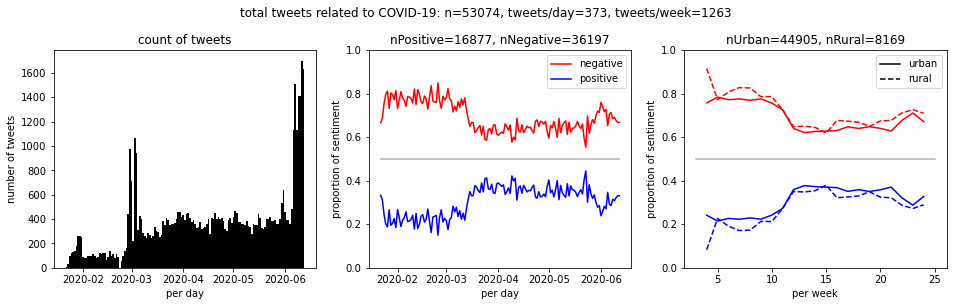

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True

ndf = cdc.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

# urban rural split by weeks
df = cdc.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
urban = df[df['is_urban'] == 1]
rural = df[df['is_urban'] == 0]
avg_wk = df['count'].mean()

# ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
# ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
ax[0].bar(ndf['date'], ndf['count'], color= 'black', label='all tweets', width=1.0)
ax[0].set_ylabel('number of tweets')
ax[0].set_xlabel('per day')
ax[0].set_title(f'count of tweets')

ax[1].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax[1].plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
ax[1].set_ylabel('proportion of sentiment')
ax[1].set_xlabel('per day')
ax[1].set_title(f'nPositive={npos}, nNegative={nneg}')
ax[1].set_ylim(0,1)
ax[1].legend()

ax[2].plot(urban['week'], urban.is_negative, color = 'r', label= 'urban')
ax[2].plot(rural['week'], rural.is_negative, color = 'r', label= 'rural', linestyle='--')
ax[2].plot(urban['week'], urban.is_positive, color = 'b')
ax[2].plot(rural['week'], rural.is_positive, color = 'b', linestyle='--')
ax[2].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
ax[2].set_ylabel('proportion of sentiment')
ax[2].set_xlabel('per week')
ax[2].set_title(f'nUrban={urban["count"].sum()}, nRural={rural["count"].sum()}')
ax[2].set_ylim(0,1)
# ax[2].set_xlim(min_wk-1,max_wk+1)
leg = ax[2].legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')

fig.suptitle(f'total tweets related to COVID-19: n={sum}, tweets/day={int(avg_day)}, tweets/week={int(avg_wk)}', y=1.03)
plt.show()


# looking at tweets in cdc subset by state

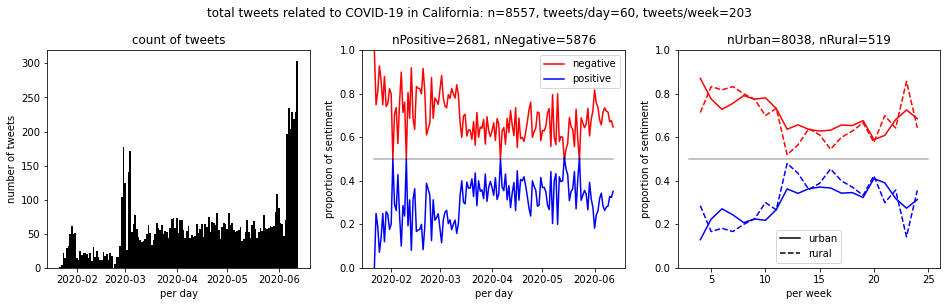

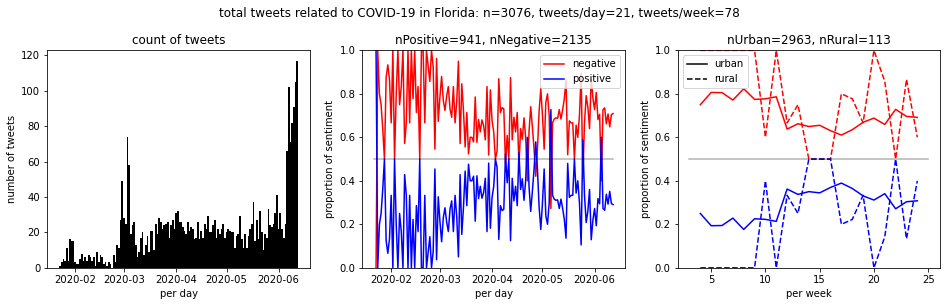

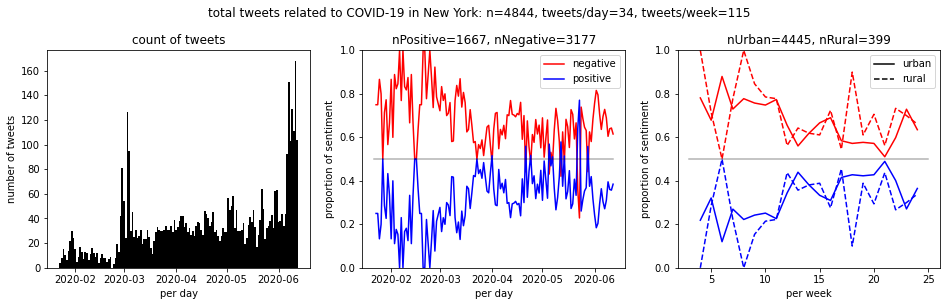

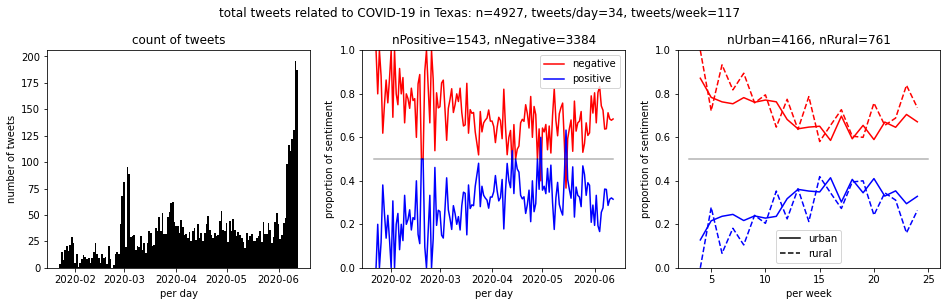

In [28]:
chosen_states = ['California', 'Texas', 'New York', 'Florida']

states = cdc[cdc['state_name'].isin(chosen_states)]

for state, df in states.groupby('state_name'):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True

    ndf = df.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
    ndf['nnegative'] = ndf['count'] * ndf['is_negative']
    ndf['npositive'] = ndf['count'] - ndf['nnegative']
    ndf['is_positive'] = 1 - ndf['is_negative']
    sum = ndf['count'].sum()
    avg_day = ndf['count'].mean()
    npos = int(ndf['npositive'].sum())
    nneg = int(ndf['nnegative'].sum())

    # urban rural split by weeks
    df = df.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
    urban = df[df['is_urban'] == 1]
    rural = df[df['is_urban'] == 0]
    avg_wk = df['count'].mean()


    # ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
    # ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
    ax[0].bar(ndf['date'], ndf['count'], color= 'black', label='all tweets', width=1.0)
    ax[0].set_ylabel('number of tweets')
    ax[0].set_xlabel('per day')
    ax[0].set_title(f'count of tweets')

    ax[1].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
    ax[1].plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
    ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    ax[1].set_ylabel('proportion of sentiment')
    ax[1].set_xlabel('per day')
    ax[1].set_title(f'nPositive={npos}, nNegative={nneg}')
    ax[1].set_ylim(0,1)
    ax[1].legend()

    ax[2].plot(urban['week'], urban.is_negative, color = 'r', label= 'urban')
    ax[2].plot(rural['week'], rural.is_negative, color = 'r', label= 'rural', linestyle='--')
    ax[2].plot(urban['week'], urban.is_positive, color = 'b')
    ax[2].plot(rural['week'], rural.is_positive, color = 'b', linestyle='--')
    ax[2].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    ax[2].set_ylabel('proportion of sentiment')
    ax[2].set_xlabel('per week')
    ax[2].set_title(f'nUrban={urban["count"].sum()}, nRural={rural["count"].sum()}')
    ax[2].set_ylim(0,1)
    # ax[2].set_xlim(min_wk-1,max_wk+1)
    leg = ax[2].legend()
    leg.legendHandles[0].set_color('black')
    leg.legendHandles[1].set_color('black')

    fig.suptitle(f'total tweets related to COVID-19 in {state}: n={sum}, tweets/day={int(avg_day)}, tweets/week={int(avg_wk)}', y=1.03)
    plt.show()

================================================================================================================

# Aggregating the state-wide analysis to weekly, with cdc subset

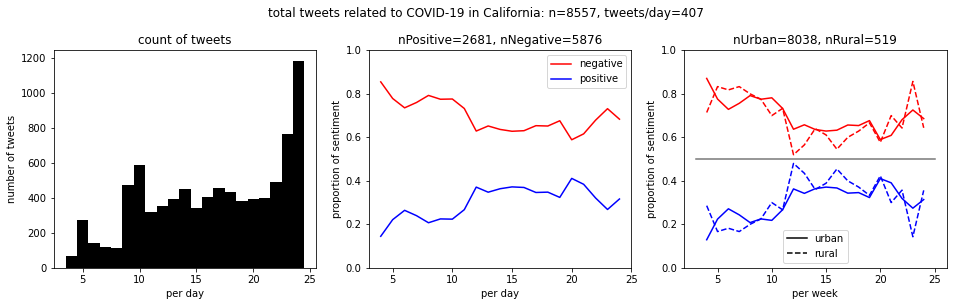

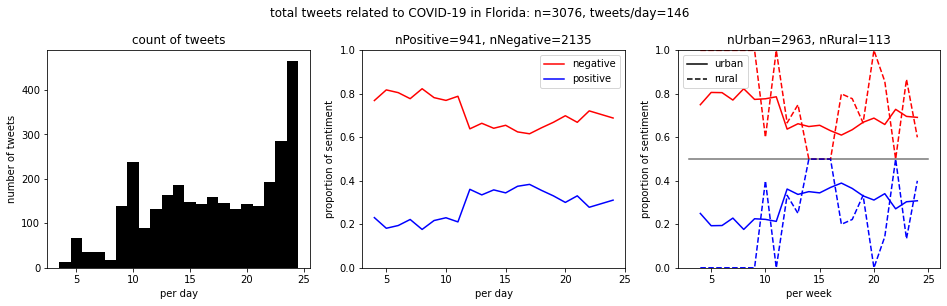

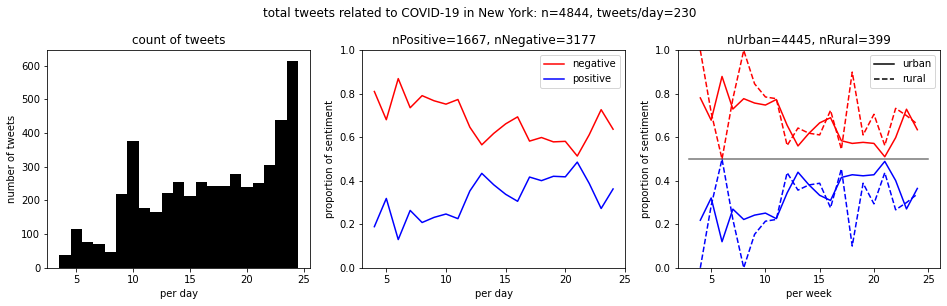

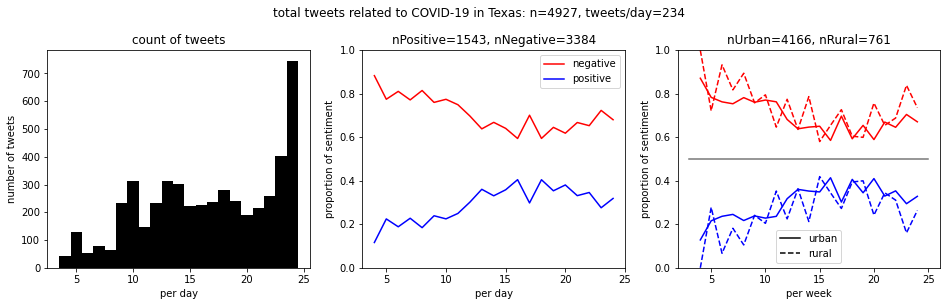

In [35]:
chosen_states = ['California', 'Texas', 'New York', 'Florida']

states = cdc[cdc['state_name'].isin(chosen_states)]

for state, df in states.groupby('state_name'):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True

    ndf = df.groupby(['week']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
    ndf['nnegative'] = ndf['count'] * ndf['is_negative']
    ndf['npositive'] = ndf['count'] - ndf['nnegative']
    ndf['is_positive'] = 1 - ndf['is_negative']
    sum = ndf['count'].sum()
    avg_day = ndf['count'].mean()
    npos = int(ndf['npositive'].sum())
    nneg = int(ndf['nnegative'].sum())

    # urban rural split by weeks
    df = df.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
    urban = df[df['is_urban'] == 1]
    rural = df[df['is_urban'] == 0]
    avg_wk = df['count'].mean()


    # ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
    # ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
    ax[0].bar(ndf['week'], ndf['count'], color= 'black', label='all tweets', width=1.0)
    ax[0].set_ylabel('number of tweets')
    ax[0].set_xlabel('per day')
    ax[0].set_title(f'count of tweets')

    ax[1].plot(ndf['week'], ndf.is_negative, color= 'r', label='negative')
    ax[1].plot(ndf['week'], ndf.is_positive, color = 'b', label='positive')
    # ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    ax[1].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    ax[1].set_ylabel('proportion of sentiment')
    ax[1].set_xlabel('per day')
    ax[1].set_title(f'nPositive={npos}, nNegative={nneg}')
    ax[1].set_ylim(0,1)
    ax[1].legend()

    ax[2].plot(urban['week'], urban.is_negative, color = 'r', label= 'urban')
    ax[2].plot(rural['week'], rural.is_negative, color = 'r', label= 'rural', linestyle='--')
    ax[2].plot(urban['week'], urban.is_positive, color = 'b')
    ax[2].plot(rural['week'], rural.is_positive, color = 'b', linestyle='--')
    ax[2].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    ax[2].set_ylabel('proportion of sentiment')
    ax[2].set_xlabel('per week')
    ax[2].set_title(f'nUrban={urban["count"].sum()}, nRural={rural["count"].sum()}')
    ax[2].set_ylim(0,1)
    # ax[2].set_xlim(min_wk-1,max_wk+1)
    leg = ax[2].legend()
    leg.legendHandles[0].set_color('black')
    leg.legendHandles[1].set_color('black')

    fig.suptitle(f'total tweets related to COVID-19 in {state}: n={sum}, tweets/day={int(avg_day)}', y=1.03)
    plt.show()

# Aggregating all tweets into weekly analysis, not cdc subset

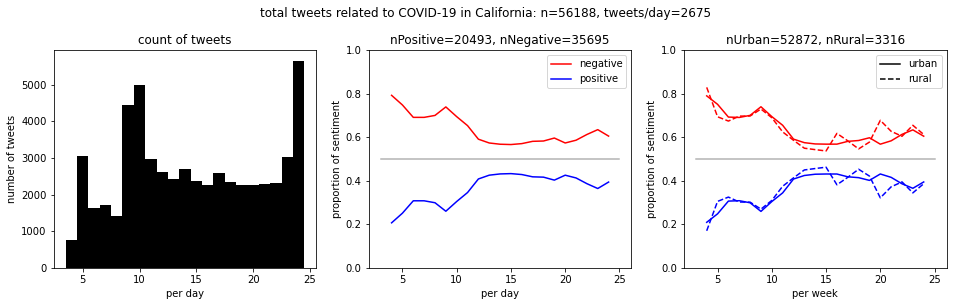

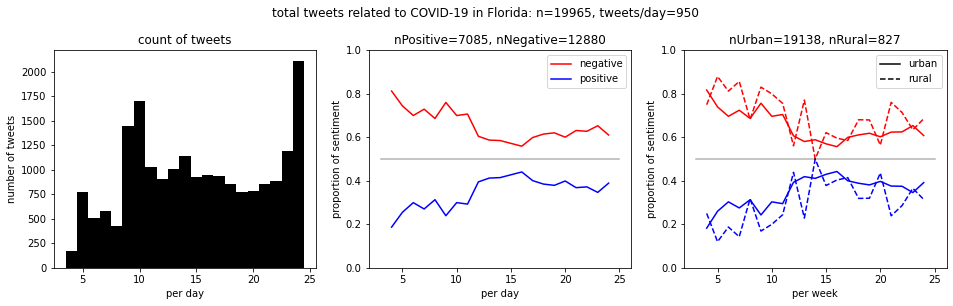

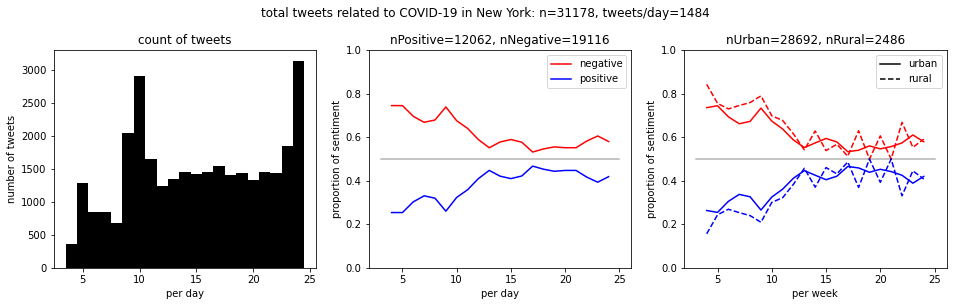

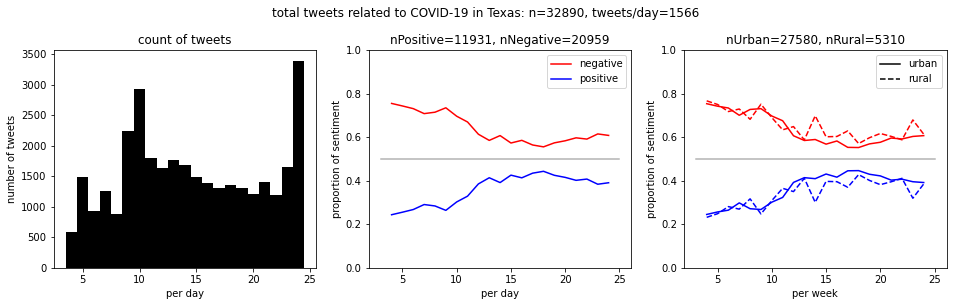

In [36]:
chosen_states = ['California', 'Texas', 'New York', 'Florida']

states = raw[raw['state_name'].isin(chosen_states)]

for state, df in states.groupby('state_name'):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True

    ndf = df.groupby(['week']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
    ndf['nnegative'] = ndf['count'] * ndf['is_negative']
    ndf['npositive'] = ndf['count'] - ndf['nnegative']
    ndf['is_positive'] = 1 - ndf['is_negative']
    sum = ndf['count'].sum()
    avg_day = ndf['count'].mean()
    npos = int(ndf['npositive'].sum())
    nneg = int(ndf['nnegative'].sum())

    # urban rural split by weeks
    df = df.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
    urban = df[df['is_urban'] == 1]
    rural = df[df['is_urban'] == 0]
    avg_wk = df['count'].mean()


    # ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
    # ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
    ax[0].bar(ndf['week'], ndf['count'], color= 'black', label='all tweets', width=1.0)
    ax[0].set_ylabel('number of tweets')
    ax[0].set_xlabel('per day')
    ax[0].set_title(f'count of tweets')

    ax[1].plot(ndf['week'], ndf.is_negative, color= 'r', label='negative')
    ax[1].plot(ndf['week'], ndf.is_positive, color = 'b', label='positive')
    # ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    ax[1].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    ax[1].set_ylabel('proportion of sentiment')
    ax[1].set_xlabel('per day')
    ax[1].set_title(f'nPositive={npos}, nNegative={nneg}')
    ax[1].set_ylim(0,1)
    ax[1].legend()

    ax[2].plot(urban['week'], urban.is_negative, color = 'r', label= 'urban')
    ax[2].plot(rural['week'], rural.is_negative, color = 'r', label= 'rural', linestyle='--')
    ax[2].plot(urban['week'], urban.is_positive, color = 'b')
    ax[2].plot(rural['week'], rural.is_positive, color = 'b', linestyle='--')
    ax[2].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    ax[2].set_ylabel('proportion of sentiment')
    ax[2].set_xlabel('per week')
    ax[2].set_title(f'nUrban={urban["count"].sum()}, nRural={rural["count"].sum()}')
    ax[2].set_ylim(0,1)
    # ax[2].set_xlim(min_wk-1,max_wk+1)
    leg = ax[2].legend()
    leg.legendHandles[0].set_color('black')
    leg.legendHandles[1].set_color('black')

    fig.suptitle(f'total tweets related to COVID-19 in {state}: n={sum}, tweets/day={int(avg_day)}', y=1.03)
    plt.show()